In [1]:
import matplotlib.pyplot as plt
import numpy as np

import iris
import iris.quickplot as qplt

%matplotlib inline

In [2]:
fname = '/g/data/r87/dbi599/ohc-metrics_Omon_ACCESS1-0_historical_r1i1p1_all.nc'

In [3]:
cube_globe = iris.load_cube(fname, 'ocean heat content over globe')
cube_sthext = iris.load_cube(fname, 'ocean heat content over southern extratropics')
cube_notsthext = iris.load_cube(fname, 'ocean heat content over outside southern extratropics')

/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:1139: UserWarning: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warnings.warn(msg)


In [4]:
print cube_globe

ocean heat content over globe / (10^22 J m-2) (time: 1872)
     Dimension coordinates:
          time                                     x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_ACCESS1-0_historical_r0i0p0.nc...
          branch_time: 109207.0
          cmor_version: 2.8.0
          contact: The ACCESS wiki: http://wiki.csiro.au/confluence/display/ACCESS/Home. Contact...
          depth_bounds: OHC integrated over full depth of input data (5.000000 down to 5831.29...
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113,...
          frequency: mon
          history: Wed May 11 09:16:51 2016: /g/data/r87/dbi599/miniconda2/envs/default/bin/python...
          initialization_method: 1
          institute_id: CSIRO-BOM
          institution: CSIRO (Commonwealth S

In [5]:
cube_globe = cube_globe.rolling_window('time', iris.analysis.MEAN, 12)
cube_sthext = cube_sthext.rolling_window('time', iris.analysis.MEAN, 12)
cube_notsthext = cube_notsthext.rolling_window('time', iris.analysis.MEAN, 12)

/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/cube.py:3381: UserWarning: The bounds of coordinate u'time' were ignored in the rolling window operation.
  'the rolling window operation.' % coord_.name())


In [6]:
print cube_globe

ocean heat content over globe / (10^22 J m-2) (time: 1861)
     Dimension coordinates:
          time                                     x
     Attributes:
          Conventions: CF-1.5
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_ACCESS1-0_historical_r0i0p0.nc...
          branch_time: 109207.0
          cmor_version: 2.8.0
          contact: The ACCESS wiki: http://wiki.csiro.au/confluence/display/ACCESS/Home. Contact...
          depth_bounds: OHC integrated over full depth of input data (5.000000 down to 5831.29...
          experiment: historical
          experiment_id: historical
          forcing: GHG, Oz, SA, Sl, Vl, BC, OC, (GHG = CO2, N2O, CH4, CFC11, CFC12, CFC113,...
          frequency: mon
          history: Wed May 11 09:16:51 2016: /g/data/r87/dbi599/miniconda2/envs/default/bin/python...
          initialization_method: 1
          institute_id: CSIRO-BOM
          institution: CSIRO (Commonwealth S

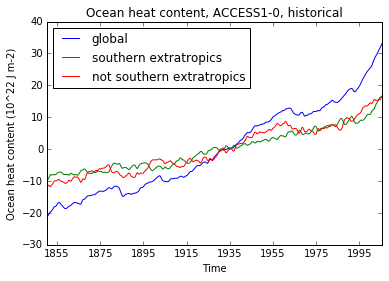

In [7]:
qplt.plot(cube_globe.coord('time'), cube_globe, label='global')
qplt.plot(cube_sthext.coord('time'), cube_sthext, label='southern extratropics')
qplt.plot(cube_notsthext.coord('time'), cube_notsthext, label='not southern extratropics')

plt.legend(loc='best')
plt.title('Ocean heat content, ACCESS1-0, historical')
plt.ylabel('Ocean heat content (%s)' %(cube_globe.units))

qplt.show()

In [8]:
ratio = cube_sthext / cube_notsthext

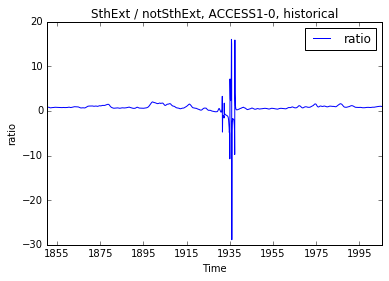

In [11]:
qplt.plot(ratio.coord('time'), ratio, label='ratio')

plt.legend(loc='best')
plt.title('SthExt / notSthExt, ACCESS1-0, historical')
plt.ylabel('ratio')

qplt.show()